In [ ]:
pip install opencv-python numpy matplotlib

In [1]:
import os
import cv2
import numpy as np
from matplotlib import pyplot as plt

Matplotlib is building the font cache; this may take a moment.


Detected circles: 6
Tomato indices and statuses:
Tomato #1: Ripe
Tomato #2: Half-Ripe
Tomato #3: Half-Ripe
Tomato #4: Ripe
Tomato #5: Unripe
Tomato #6: Unripe


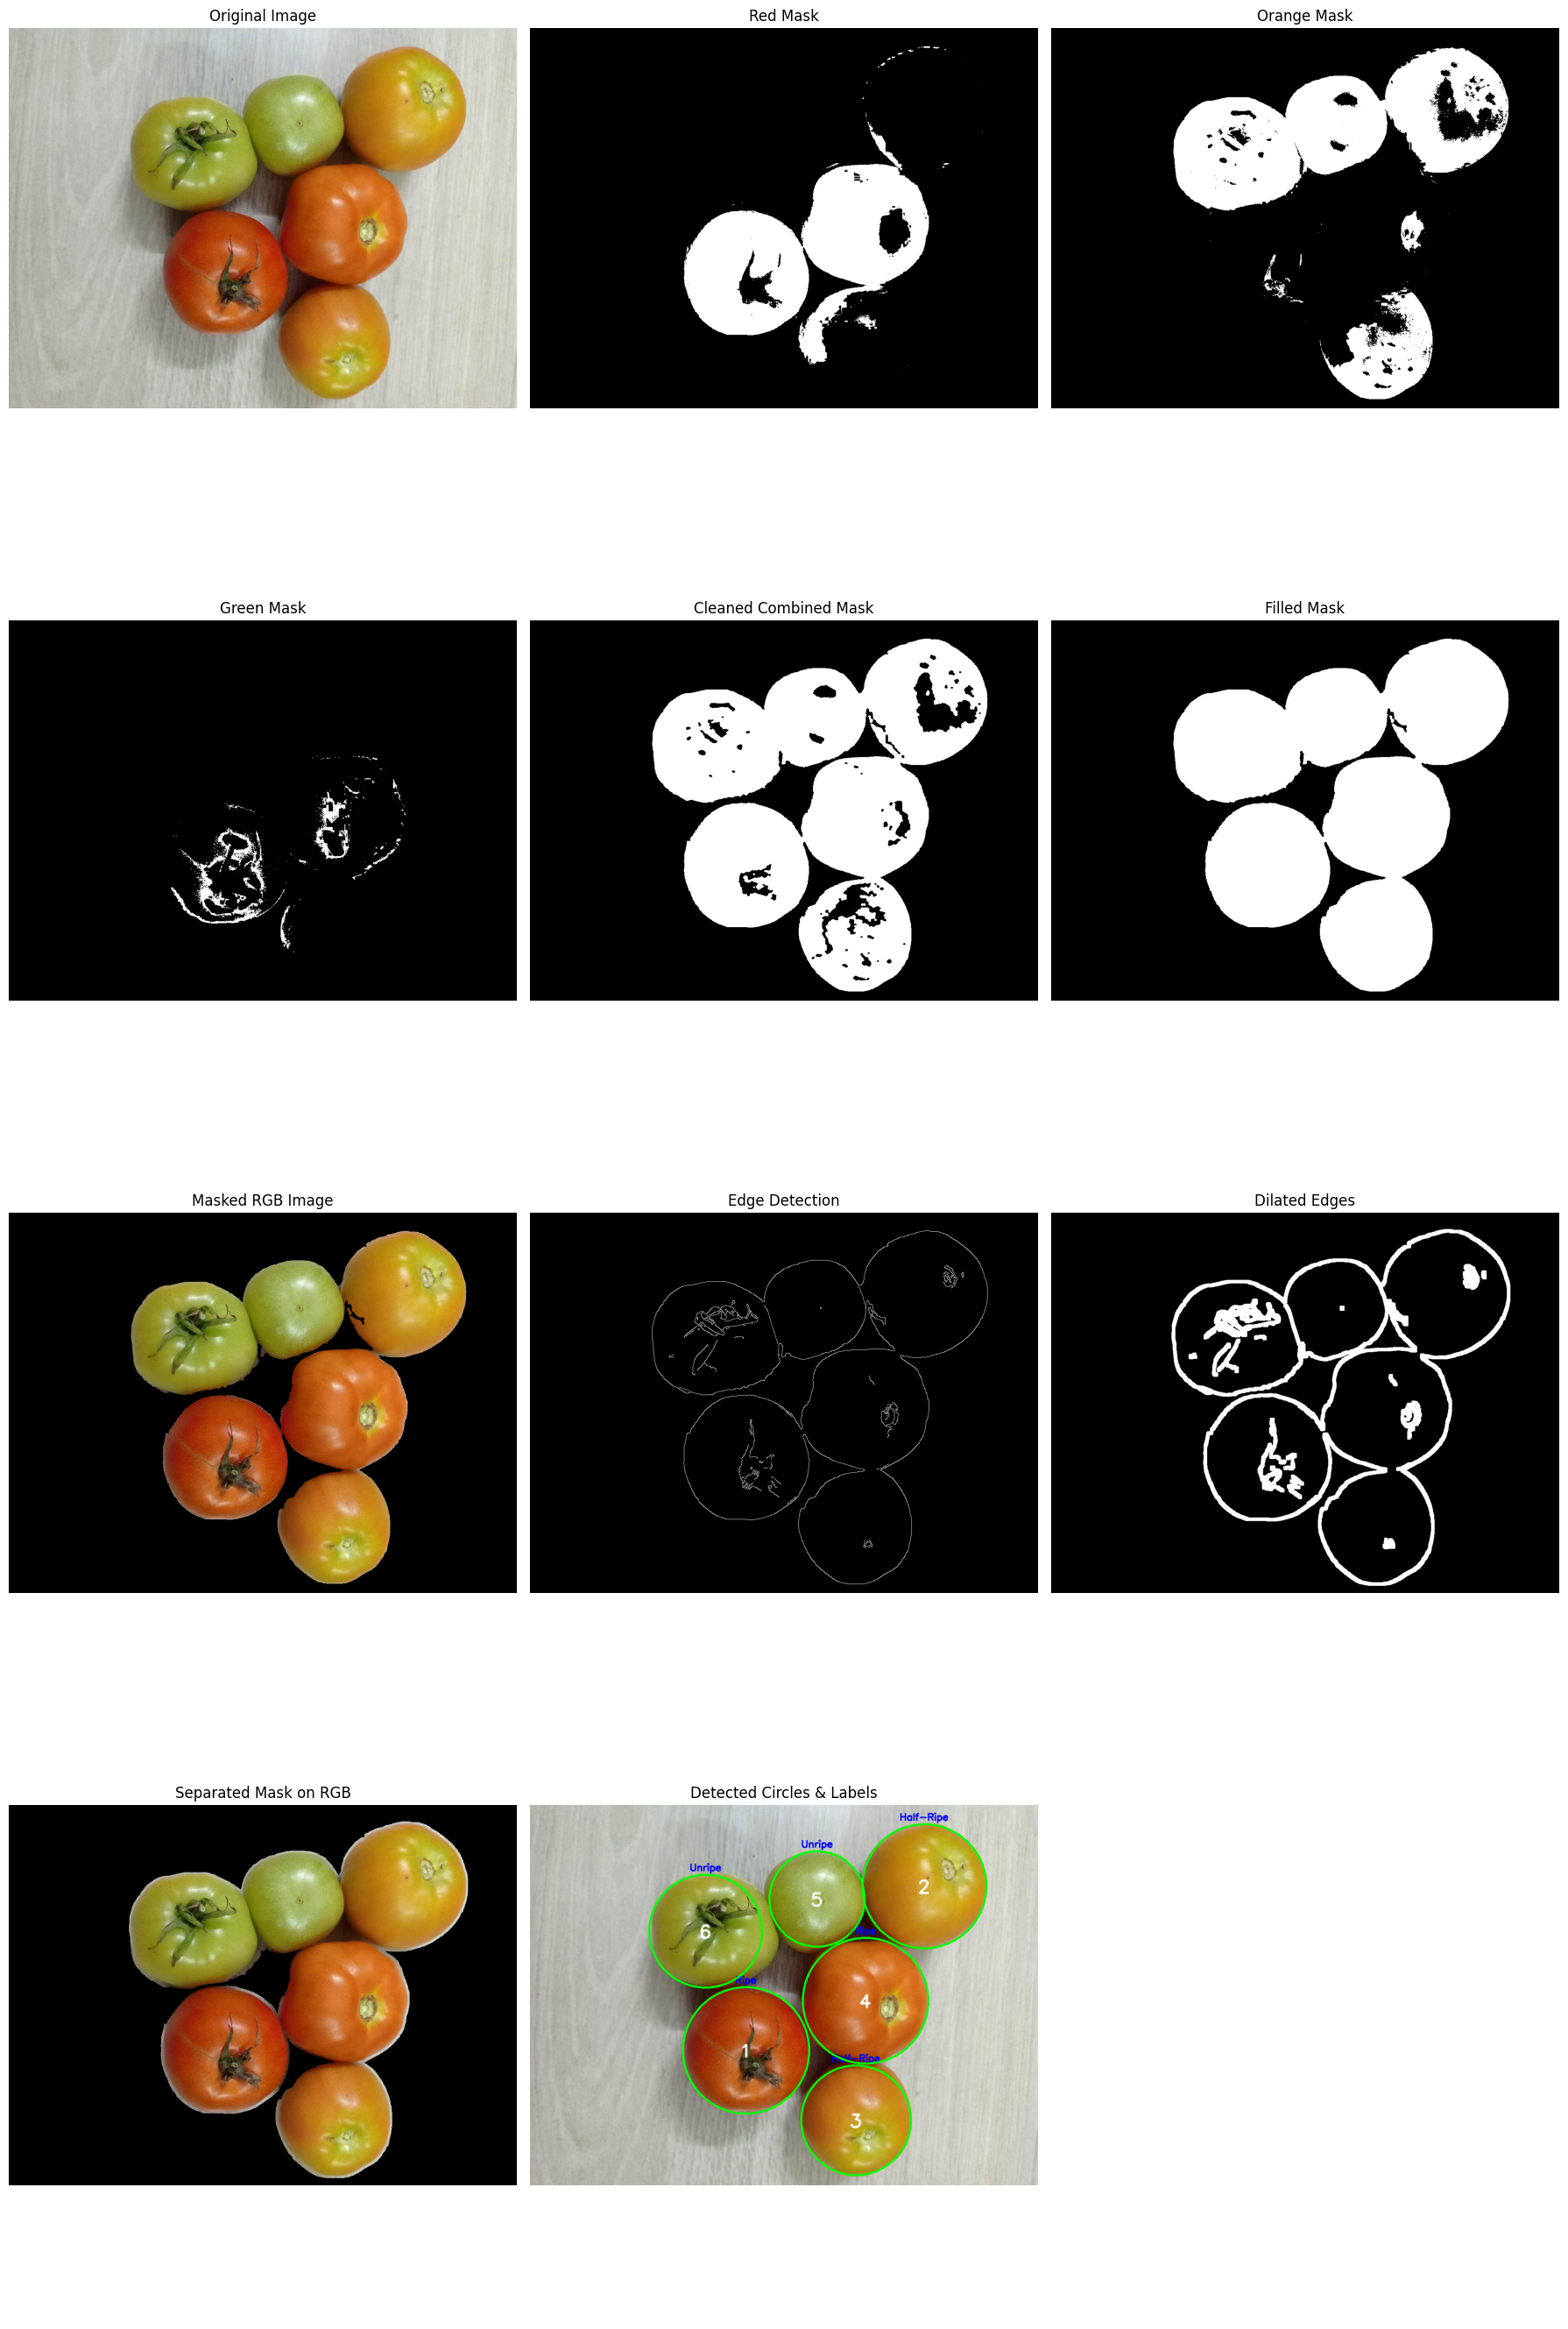

Saved outputs: image_with_circles_and_labels.jpg, report_grid.png, and other masks in 'outputs/'.


In [3]:
def classify_tomato(hue_val):
    """
    Classify a tomato's ripeness based on the mean Hue value.
    NOTE:
      - Ripe       : Hue in [0, 15]
      - Half-Ripe  : Hue in [16, 24]
      - Unripe     : Otherwise
    These thresholds come from your updated tuning window.
    """
    if 0 <= hue_val <= 15:        # Ripe range
        return "Ripe"
    elif 16 <= hue_val <= 24:     # Half-Ripe range
        return "Half-Ripe"
    else:
        return "Unripe"

def main():
    # ----------- Config -----------
    image_path = "img/1 (122).jpg"   # Change to your desired image path
    out_dir = "outputs"              # All outputs will be saved here
    os.makedirs(out_dir, exist_ok=True)

    # ----------- Load Image -----------
    image = cv2.imread(image_path)
    if image is None:
        print("Error: image not found or could not be loaded.")
        return

    # Convert BGR -> RGB -> HSV
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image_hsv = cv2.cvtColor(image_rgb, cv2.COLOR_RGB2HSV)

    # ----------- Step 1: Define HSV thresholds -----------
    # NOTE: These are taken from your code (as tuned). Keep or adjust as needed.
    lower_red    = np.array([0, 54, 116])
    upper_red    = np.array([14, 255, 255])

    lower_orange = np.array([16, 72, 69])
    upper_orange = np.array([47, 255, 205])

    lower_green  = np.array([8, 183, 109])
    upper_green  = np.array([12, 217, 226])
    # NOTE: The "green" window here (H≈8..12) looks close to red/orange hues in standard HSV (0..179 in OpenCV).
    # It matches your original code; if results look off, re-check this band.

    # ----------- Step 2: Build masks per color -----------
    mask_red    = cv2.inRange(image_hsv, lower_red,    upper_red)
    mask_orange = cv2.inRange(image_hsv, lower_orange, upper_orange)
    mask_green  = cv2.inRange(image_hsv, lower_green,  upper_green)

    # ----------- Step 3: Combine masks -----------
    combined_mask = cv2.bitwise_or(mask_red, mask_orange)
    combined_mask = cv2.bitwise_or(combined_mask, mask_green)

    # ----------- Step 4: Morphology to clean mask -----------
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5, 5))
    cleaned_mask = cv2.morphologyEx(combined_mask, cv2.MORPH_CLOSE, kernel)
    cleaned_mask = cv2.morphologyEx(cleaned_mask, cv2.MORPH_OPEN,  kernel)

    # ----------- Step 5: Fill small holes inside the mask -----------
    filled_mask = cleaned_mask.copy()
    contours, _ = cv2.findContours(filled_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    for contour in contours:
        cv2.drawContours(filled_mask, [contour], -1, 255, thickness=cv2.FILLED)

    # ----------- Step 6: Mask original image with the filled mask -----------
    filled_mask_rgb = cv2.bitwise_and(image_rgb, image_rgb, mask=filled_mask)

    # ----------- Step 7: Edge detection + dilation to separate touching objects -----------
    filled_mask_gray = cv2.cvtColor(filled_mask_rgb, cv2.COLOR_RGB2GRAY)
    blurred = cv2.GaussianBlur(filled_mask_gray, (5, 5), 0)
    edges = cv2.Canny(blurred, 50, 150)

    # Dilate edges to split connected areas better
    dilate_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (5, 5))
    dilated_edges = cv2.dilate(edges, dilate_kernel, iterations=2)

    # Fill regions detected by dilated edges (filter out tiny noise by area)
    separated_mask = np.zeros_like(dilated_edges)
    contours, _ = cv2.findContours(dilated_edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    for contour in contours:
        if cv2.contourArea(contour) > 50:  # Ignore tiny regions
            cv2.drawContours(separated_mask, [contour], -1, 255, thickness=cv2.FILLED)

    separated_mask_rgb = cv2.bitwise_and(image_rgb, image_rgb, mask=separated_mask)

    # ----------- Step 8: Detect circles via HoughCircles -----------
    # Use edges -> blur a bit more for Hough
    blur_for_circles = cv2.GaussianBlur(edges, (9, 9), 2)
    circles = cv2.HoughCircles(
        blur_for_circles,
        cv2.HOUGH_GRADIENT,
        dp=1.56,           # Inverse ratio of the accumulator resolution
        minDist=200,       # Minimum distance between circle centers
        param1=109,        # Upper threshold for Canny (lower is half internally)
        param2=64,         # Accumulator threshold for circle centers
        minRadius=97,      # Minimum radius
        maxRadius=191,     # Maximum radius
    )

    # Prepare drawing canvas + storage
    image_with_circles = image_rgb.copy()
    filtered_circles = []
    circle_labels = {}  # {index: "Ripe/Half-Ripe/Unripe"}

    # Filter circles by radius range and round to int
    if circles is not None:
        circles = np.round(circles[0, :]).astype("int")
        for (x, y, r) in circles:
            if 90 <= r <= 200:
                filtered_circles.append((x, y, r))

    # ----------- Classify each detected circle -----------
    for idx, (x, y, r) in enumerate(filtered_circles):
        # Create a circular mask for this detected tomato
        circle_mask = np.zeros((image_hsv.shape[0], image_hsv.shape[1]), dtype=np.uint8)
        cv2.circle(circle_mask, (x, y), r, 255, -1)

        # Compute mean HSV in the circle area
        mean_hsv = cv2.mean(image_hsv, mask=circle_mask)
        mean_hue = mean_hsv[0]  # Hue channel

        # Classify based on Hue
        status = classify_tomato(mean_hue)
        circle_labels[idx + 1] = status

        # Draw the circle
        cv2.circle(image_with_circles, (x, y), r, (0, 255, 0), 3)

        # Draw the index at the center
        font_scale = 1.5
        font_thickness = 3
        text = str(idx + 1)
        text_size, _ = cv2.getTextSize(text, cv2.FONT_HERSHEY_SIMPLEX, font_scale, font_thickness)
        text_x = x - text_size[0] // 2
        text_y = y + text_size[1] // 2
        cv2.putText(
            image_with_circles,
            text,
            (text_x, text_y),
            cv2.FONT_HERSHEY_SIMPLEX,
            font_scale,
            (255, 255, 255),
            font_thickness,
            cv2.LINE_AA
        )

        # Put the ripeness label above the circle
        label_text = f"{status}"
        label_font_scale = 0.8
        label_thickness = 2
        label_size, _ = cv2.getTextSize(label_text, cv2.FONT_HERSHEY_SIMPLEX, label_font_scale, label_thickness)
        label_x = x - label_size[0] // 2
        label_y = y - r - 10
        cv2.putText(
            image_with_circles,
            label_text,
            (label_x, label_y),
            cv2.FONT_HERSHEY_SIMPLEX,
            label_font_scale,
            (0, 0, 255),
            label_thickness,
            cv2.LINE_AA
        )

    # ----------- Console summary -----------
    print(f"Detected circles: {len(filtered_circles)}")
    print("Tomato indices and statuses:")
    for label, status in circle_labels.items():
        print(f"Tomato #{label}: {status}")

    # ----------- Save outputs -----------
    cv2.imwrite(os.path.join(out_dir, "image_with_circles_and_labels.jpg"),
                cv2.cvtColor(image_with_circles, cv2.COLOR_RGB2BGR))
    cv2.imwrite(os.path.join(out_dir, "filled_mask.jpg"), filled_mask)
    cv2.imwrite(os.path.join(out_dir, "filled_mask_rgb.jpg"),
                cv2.cvtColor(filled_mask_rgb, cv2.COLOR_RGB2BGR))
    cv2.imwrite(os.path.join(out_dir, "edges.jpg"), edges)
    cv2.imwrite(os.path.join(out_dir, "dilated_edges.jpg"), dilated_edges)
    cv2.imwrite(os.path.join(out_dir, "separated_mask_rgb.jpg"),
                cv2.cvtColor(separated_mask_rgb, cv2.COLOR_RGB2BGR))

    # ----------- Visual report via Matplotlib -----------
    fig, axes = plt.subplots(4, 3, figsize=(18, 28))

    axes[0, 0].imshow(image_rgb)
    axes[0, 0].set_title("Original Image")
    axes[0, 0].axis("off")

    axes[0, 1].imshow(mask_red, cmap="gray")
    axes[0, 1].set_title("Red Mask")
    axes[0, 1].axis("off")

    axes[0, 2].imshow(mask_orange, cmap="gray")
    axes[0, 2].set_title("Orange Mask")
    axes[0, 2].axis("off")

    axes[1, 0].imshow(mask_green, cmap="gray")
    axes[1, 0].set_title("Green Mask")
    axes[1, 0].axis("off")

    axes[1, 1].imshow(cleaned_mask, cmap="gray")
    axes[1, 1].set_title("Cleaned Combined Mask")
    axes[1, 1].axis("off")

    axes[1, 2].imshow(filled_mask, cmap="gray")
    axes[1, 2].set_title("Filled Mask")
    axes[1, 2].axis("off")

    axes[2, 0].imshow(filled_mask_rgb)
    axes[2, 0].set_title("Masked RGB Image")
    axes[2, 0].axis("off")

    axes[2, 1].imshow(edges, cmap="gray")
    axes[2, 1].set_title("Edge Detection")
    axes[2, 1].axis("off")

    axes[2, 2].imshow(dilated_edges, cmap="gray")
    axes[2, 2].set_title("Dilated Edges")
    axes[2, 2].axis("off")

    axes[3, 0].imshow(separated_mask_rgb)
    axes[3, 0].set_title("Separated Mask on RGB")
    axes[3, 0].axis("off")

    axes[3, 1].imshow(image_with_circles)
    axes[3, 1].set_title("Detected Circles & Labels")
    axes[3, 1].axis("off")

    axes[3, 2].axis("off")  # blank

    plt.tight_layout()
    plt.savefig(os.path.join(out_dir, "report_grid.png"), dpi=150)
    plt.show()

    print("Saved outputs: image_with_circles_and_labels.jpg, report_grid.png, and other masks in 'outputs/'.")

if __name__ == "__main__":
    main()
